In [1]:
import pickle
import timeit
import pandas as pd
import numpy as np
from numpy.random import permutation
from scipy import stats
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from spdt import NaiveStreamForest, CascadeStreamForest

In [2]:
sns.set(color_codes=True, style='white', context='talk', font_scale=1.5)
PALETTE = sns.color_palette("Set1")

In [3]:
def prediction(classifier):
    predictions = classifier.predict(X_test)

    p_t = 0
    for i in range(X_test.shape[0]):
        if predictions[i] == y_test[i]:
            p_t += 1

    return p_t / X_test.shape[0]

## Stream Forests

In [4]:
def experiment_small_rf():
    rf_l = []

    rf = RandomForestClassifier(n_jobs=-1)

    for i in range(74):
        rf.fit(X_r[: (i + 1) * 100], y_r[: (i + 1) * 100])
        rf_l.append(prediction(rf))

    return rf_l


def experiment_small_et():
    rf_l = []

    rf = ExtraTreesClassifier(n_jobs=-1)

    for i in range(74):
        rf.fit(X_r[: (i + 1) * 100], y_r[: (i + 1) * 100])
        rf_l.append(prediction(rf))

    return rf_l


def experiment_small_dt():
    dt_l = []

    dt = DecisionTreeClassifier()

    for i in range(74):
        dt.fit(X_r[: (i + 1) * 100], y_r[: (i + 1) * 100])
        dt_l.append(prediction(dt))

    return dt_l


def experiment_small_s():
    sdt_l = []
    nsf_l = []
    csf_l = []
    net_l = []
    cet_l = []

    sdt = DecisionTreeClassifier()
    nsf = NaiveStreamForest()
    csf = CascadeStreamForest()
    net = NaiveStreamForest(splitter="random")
    cet = CascadeStreamForest(splitter="random")

    for i in range(74):
        X_t = X_r[i * 100 : (i + 1) * 100]
        y_t = y_r[i * 100 : (i + 1) * 100]

        sdt.partial_fit(X_t, y_t)
        sdt_l.append(prediction(sdt))

        nsf.fit(X_t, y_t)
        nsf_l.append(prediction(nsf))

        csf.fit(X_t, y_t)
        csf_l.append(prediction(csf))

        net.fit(X_t, y_t)
        net_l.append(prediction(net))

        cet.fit(X_t, y_t)
        cet_l.append(prediction(cet))

    return sdt_l, nsf_l, csf_l, net_l, cet_l

In [11]:
results = []
pendigits = pd.read_csv("pendigits.tra", header=None)
pendigits_test = pd.read_csv("pendigits.tes", header=None)
X_test = pendigits_test.iloc[:, :-1]
y_test = pendigits_test.iloc[:, -1]

for i in range(10):
    p = pendigits.sample(frac=1)
    X_r = p.iloc[:, :-1]
    y_r = p.iloc[:, -1]

    result = []
    result.append(experiment_small_rf())
    result.append(experiment_small_et())
    result.append(experiment_small_dt())
    sdt_l, nsf_l, csf_l, net_l, cet_l = experiment_small_s()
    result.append(sdt_l)
    result.append(nsf_l)
    result.append(csf_l)
    result.append(net_l)
    result.append(cet_l)
    results.append(result)

    with open("pen_results.txt", "wb") as f:
        pickle.dump(results, f)

In [13]:
with open("pen_results.txt", "rb") as f:
    results = pickle.load(f)

In [60]:
SETUP = ""

rf_time = []
num = [100, 1000, 2000, 3000, 4000, 5000, 6000, 7000]
for n in num:
    TEST = """
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
pendigits = pd.read_csv("pendigits.tra", header=None)
pendigits_test = pd.read_csv("pendigits.tes", header=None)
X_test = pendigits_test.iloc[:, :-1]
y_test = pendigits_test.iloc[:, -1]
p = pendigits.sample(frac=1)
X_r = p.iloc[:, :-1]
y_r = p.iloc[:, -1]

RF = RandomForestClassifier(n_estimators=100)
for i in range(1,{}):
    RF.fit(X_r[:i], y_r[:i])

predictions = RF.predict(X_test)

p_t = 0
for i in range(X_test.shape[0]):
    if predictions[i] == y_test[i]:
        p_t += 1
result = p_t / X_test.shape[0]
""".format(
        n
    )
    time = timeit.repeat(setup=SETUP, stmt=TEST, repeat=3, number=1)
    print(n)
    rf_time.append(np.mean(time))

with open("rf_time_retrained.txt", "wb") as f:
    pickle.dump(rf_time, f)

100
1000
2000
3000
4000
5000
6000
7000


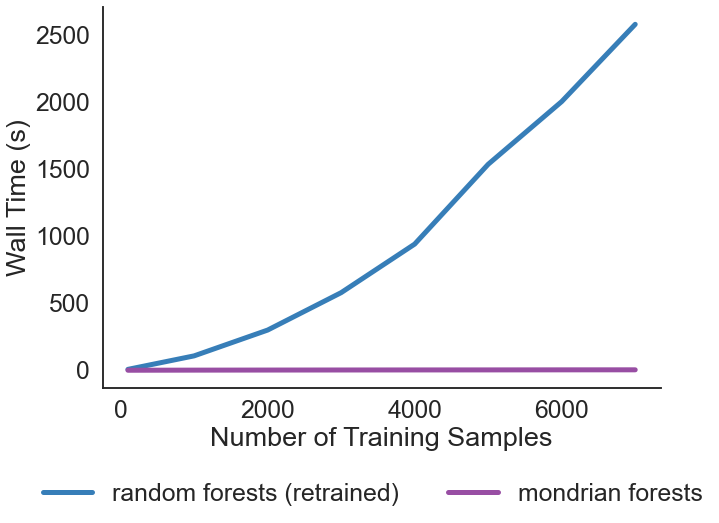

In [63]:
mon_time = [
    0.364928,
    1.236500,
    1.815187,
    2.283036,
    2.643813,
    2.917301,
    3.357287,
    3.567565,
]

fig = plt.figure(figsize=(10,7))
ax = plt.subplot(111)

ax.set_xlabel("Number of Training Samples")
ax.set_ylabel("Wall Time (s)")
ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)

plt.plot(num, rf_time, label="random forests (retrained)",lw=5,color="#377eb8")
plt.plot(num, mon_time, label="mondrian forests",lw=5,color="#984ea3")
leg = plt.legend(bbox_to_anchor=(0.5, -0.02), bbox_transform=plt.gcf().transFigure,
                     ncol=2, loc='upper center')
leg.get_frame().set_linewidth(0.0)
for legobj in leg.legendHandles:
    legobj.set_linewidth(5.0)

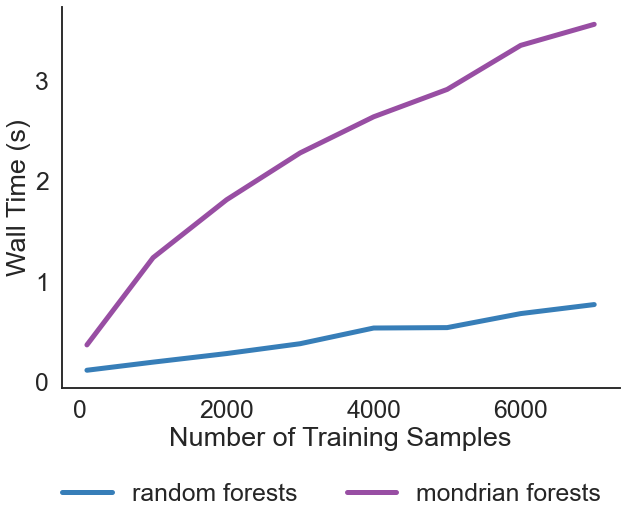

In [67]:
with open("rf_time.txt", "rb") as f:
    rf_time = pickle.load(f)

rf_time = [rf_time[99],rf_time[999],rf_time[1999],rf_time[2999],rf_time[3999],rf_time[4999],rf_time[5999],rf_time[6999]]
fig = plt.figure(figsize=(10,7))
ax = plt.subplot(111)

ax.set_xlabel("Number of Training Samples")
ax.set_ylabel("Wall Time (s)")
ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)

plt.plot(num, rf_time, label="random forests",lw=5,color="#377eb8")
plt.plot(num, mon_time, label="mondrian forests",lw=5,color="#984ea3")
leg = plt.legend(bbox_to_anchor=(0.5, -0.02), bbox_transform=plt.gcf().transFigure,
                     ncol=2, loc='upper center')
leg.get_frame().set_linewidth(0.0)
for legobj in leg.legendHandles:
    legobj.set_linewidth(5.0)

In [13]:
num = [100, 170, 439, 1000, 1130, 2000, 2910, 3000, 4000, 5000, 6000, 7000, 7494]
mon = [
    0.804460,
    0.821326,
    0.908233,
    0.928531,
    0.927101,
    0.943968,
    0.950829,
    0.949114,
    0.955975,
    0.953688,
    0.961692,
    0.963122,
    0.959691,
]
ht = [
    0.756,
    0.819,
    0.814667,
    0.815667,
    0.819,
    0.823,
    0.821,
    0.82,
    0.817333,
    0.817667,
    0.766333,
    0.860333,
    0.863667,
]
hat = [
    0.746,
    0.814667,
    0.815333,
    0.819,
    0.822667,
    0.814,
    0.817667,
    0.818,
    0.862333,
    0.844,
    0.871333,
    0.871,
    0.869667,
]

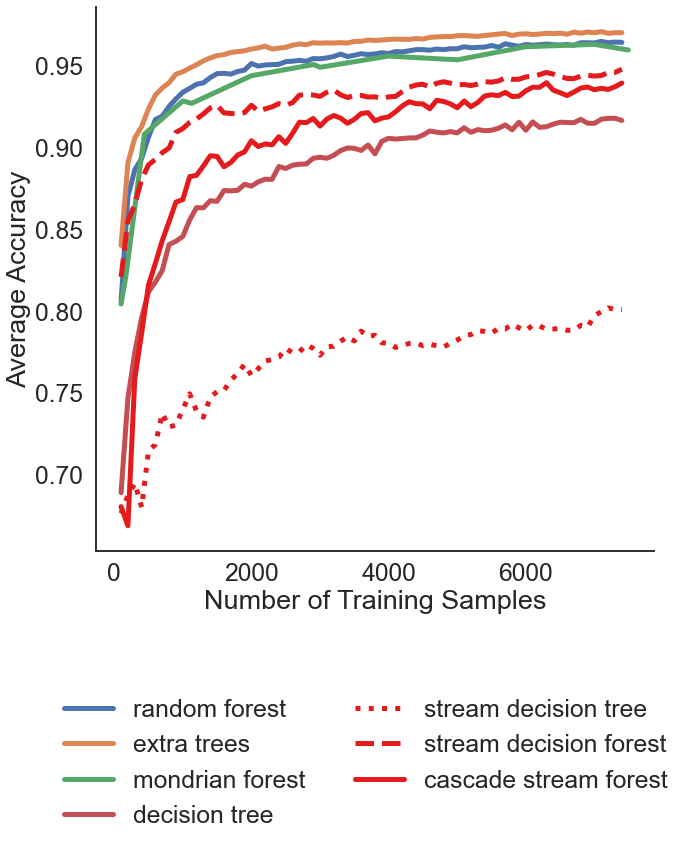

In [19]:
# impurity same version
means = np.mean(results, axis=0)

n_train = range(100, 7500, 100)
fig = plt.figure(figsize=(10, 10))
ax = plt.subplot(111)

ax.set_xlabel("Number of Training Samples")
ax.set_ylabel("Average Accuracy")
ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)

plt.plot(n_train, means[0], label="random forest", lw=5)
plt.plot(n_train, means[1], label="extra trees", lw=5)
plt.plot(num, mon, label="mondrian forest", lw=5)
plt.plot(n_train, means[2], label="decision tree", lw=5)

# plt.plot(num, ht, label="hoeffding trees", lw=5, color="#ff7f00")
# plt.plot(num, hat, label="hoeffding adaptive trees", lw=5, color="#ffff33")
plt.plot(
    n_train,
    means[3],
    label="stream decision tree",
    lw=5,
    color="#e41a1c",
    linestyle="dotted",
)
plt.plot(
    n_train,
    means[4],
    label="stream decision forest",
    lw=5,
    color="#e41a1c",
    linestyle="dashed",
)
plt.plot(n_train, means[5], label="cascade stream forest", lw=5, color="#e41a1c")
# plt.plot(n_train, means[6], label="stream extra trees", lw=5)
# plt.plot(n_train, means[7], label="cascade extra trees", lw=5)
leg = plt.legend(
    bbox_to_anchor=(0.5, -0.05),
    bbox_transform=plt.gcf().transFigure,
    ncol=2,
    loc="upper center",
)
leg.get_frame().set_linewidth(0.0)
for legobj in leg.legendHandles:
    legobj.set_linewidth(5.0)

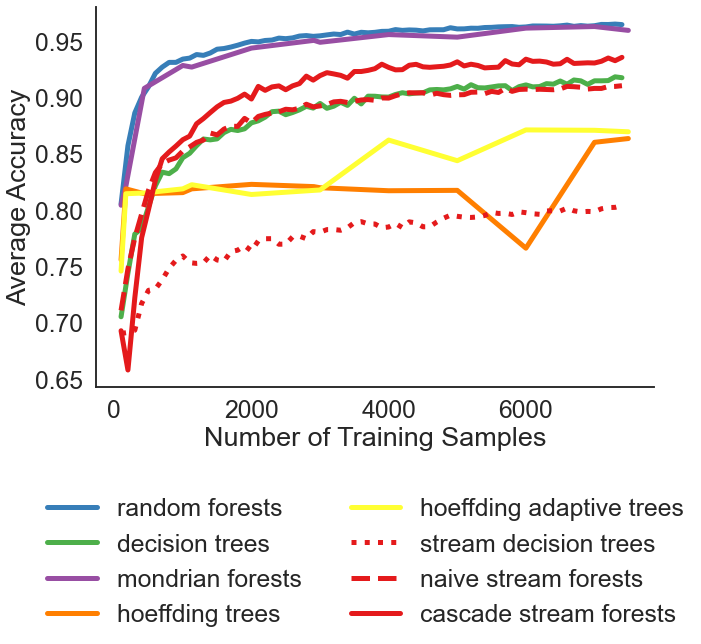

In [24]:
# impurity same version
means = np.mean(results, axis=0)

n_train = range(100, 7500, 100)
fig = plt.figure(figsize=(10, 7))
ax = plt.subplot(111)

ax.set_xlabel("Number of Training Samples")
ax.set_ylabel("Average Accuracy")
ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)

plt.plot(n_train, means[0], label="random forest", lw=5)
plt.plot(n_train, means[1], label="extra trees", lw=5)
plt.plot(n_train, mon, label="mondrian forest", lw=5)
# plt.plot(num, ht, label="hoeffding trees", lw=5, color="#ff7f00")
# plt.plot(num, hat, label="hoeffding adaptive trees", lw=5, color="#ffff33")
plt.plot(
    n_train,
    means[2],
    label="stream decision tree",
    lw=5,
    color="#e41a1c",
    linestyle="dotted",
)
plt.plot(
    n_train,
    means[3],
    label="stream decision forest",
    lw=5,
    color="#e41a1c",
    linestyle="dashed",
)
plt.plot(n_train, means[4], label="cascade stream forest", lw=5, color="#e41a1c")
plt.plot(n_train, means[5], label="stream extra trees", lw=5)
plt.plot(n_train, means[6], label="cascade extra trees", lw=5)
leg = plt.legend(
    bbox_to_anchor=(0.5, -0.05),
    bbox_transform=plt.gcf().transFigure,
    ncol=2,
    loc="upper center",
)
leg.get_frame().set_linewidth(0.0)
for legobj in leg.legendHandles:
    legobj.set_linewidth(5.0)

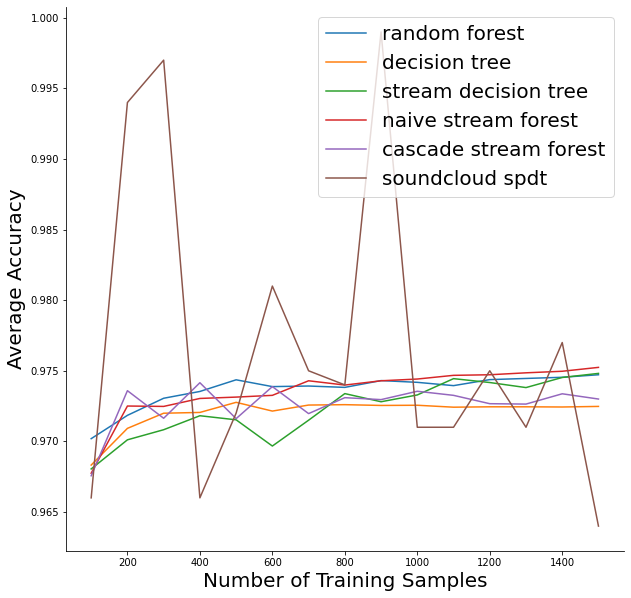

In [19]:
# impurity same version
means = np.mean(results, axis=0)

spdt = [
    0.966,
    0.994,
    0.997,
    0.966,
    0.972,
    0.981,
    0.975,
    0.974,
    0.999,
    0.971,
    0.971,
    0.975,
    0.971,
    0.977,
    0.964
]

n_train = range(100, 7500, 100)

fig, ax = plt.subplots(figsize=(10, 10))
ax.set_xlabel("Number of Training Samples", fontsize=20)
ax.set_ylabel("Average Accuracy", fontsize=20)
ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)

plt.plot(n_train, means[0], label="random forest")
plt.plot(n_train, means[1], label="decision tree")
plt.plot(n_train, means[2], label="stream decision tree")
plt.plot(n_train, means[3], label="naive stream forest")
plt.plot(n_train, means[4], label="cascade stream forest")
plt.plot(n_train, spdt, label="soundcloud spdt")
plt.legend(fontsize=20)

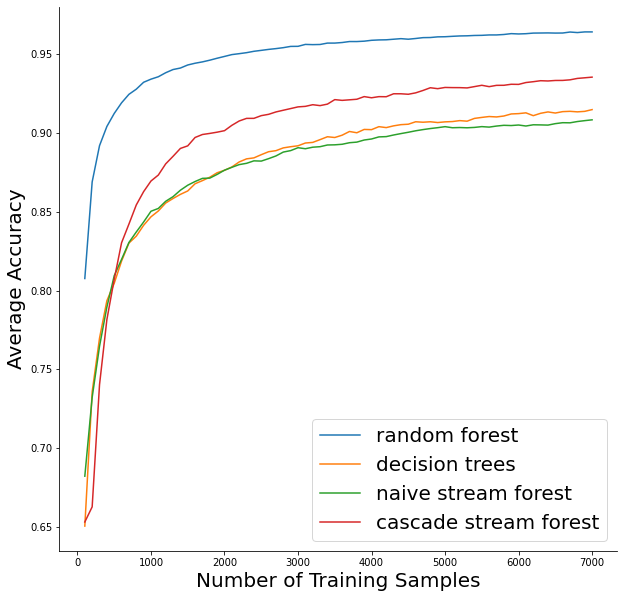

In [5]:
# impurity same version
means = np.mean(results, axis=0)

import matplotlib.pyplot as plt
%matplotlib inline

n_train = range(100, 7100, 100)

fig, ax = plt.subplots(figsize=(10, 10))
ax.set_xlabel("Number of Training Samples", fontsize = 20)
ax.set_ylabel("Average Accuracy", fontsize = 20)
ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)

plt.plot(n_train, means[0], label="random forest")
plt.plot(n_train, means[1], label="decision trees")
plt.plot(n_train, means[2], label="naive stream forest")
plt.plot(n_train, means[3], label="cascade stream forest")
plt.legend(fontsize = 20)

## Stream Decision Trees

In [7]:
def experiment_100():
    rf_l = []
    dt_l = []
    sdt_l = []

    rf = RandomForestClassifier()
    dt = DecisionTreeClassifier()
    sdt = DecisionTreeClassifier()
    not_first = False

    for i in range(70):

        rf.fit(X_r.iloc[: (i + 1) * 100], y_r.iloc[: (i + 1) * 100])
        rf_l.append(prediction(rf))

        dt.fit(X_r.iloc[: (i + 1) * 100], y_r.iloc[: (i + 1) * 100])
        dt_l.append(prediction(dt))

        X_t = X_r.iloc[i * 100 : (i + 1) * 100]
        y_t = y_r.iloc[i * 100 : (i + 1) * 100]

        sdt.fit(X_t, y_t, update_tree=not_first)
        not_first = True
        sdt_l.append(prediction(sdt))

    p_l = []
    p_l.append(rf_l)
    p_l.append(dt_l)
    p_l.append(sdt_l)

    return p_l

In [4]:
results = []
pendigits = pd.read_csv("pendigits.tra", header = None)
pendigits_test = pd.read_csv("pendigits.tes", header = None)
X_test = pendigits_test.iloc[:,:-1]
y_test = pendigits_test.iloc[:,-1]

for i in range(100):
    p = pendigits.sample(frac=1)
    X_r = p.iloc[:,:-1]
    y_r = p.iloc[:,-1]
    
    results.append(experiment_100())

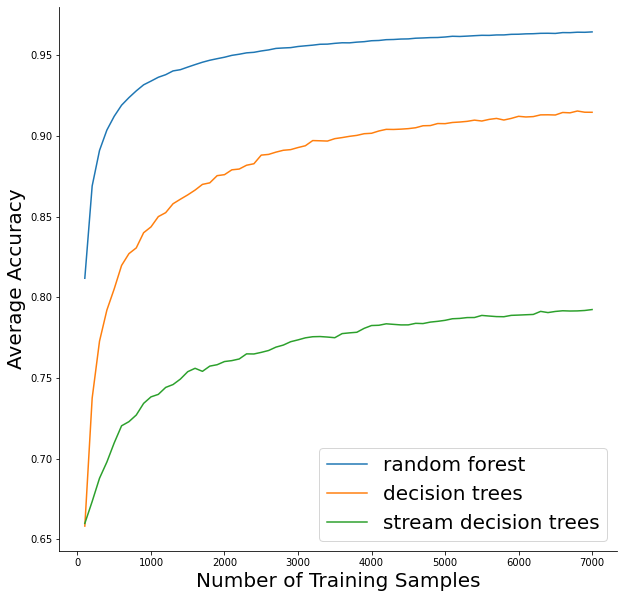

In [5]:
# impurity same version
means = np.mean(results, axis=0)

import matplotlib.pyplot as plt
%matplotlib inline

n_train = range(100, 7100, 100)

fig, ax = plt.subplots(figsize=(10, 10))
ax.set_xlabel("Number of Training Samples", fontsize = 20)
ax.set_ylabel("Average Accuracy", fontsize = 20)
ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)

plt.plot(n_train, means[0], label="random forest")
plt.plot(n_train, means[1], label="decision trees")
plt.plot(n_train, means[2], label="stream decision trees")
plt.legend(fontsize = 20)